In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.models import Sequential

from tensorflow.keras import layers


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.11.0


In [2]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
dataset_load = np.load("/kaggle/input/channelflow/channel_flow.npy")

dataset = np.expand_dims(dataset_load, axis=3)
dataset_inp = np.repeat(dataset, 3,axis=3)
coarse_dataset_4 = dataset_inp[:,3::4,3::4,:]
coarse_dataset_8 = dataset_inp[:,3::8,3::8,:]

train_dataset = dataset_inp[:490]
train_coarse_8 = coarse_dataset_8[:490]
train_coarse_4 = coarse_dataset_4[:490]
test_dataset = dataset_inp[490:]
test_coarse_8 = coarse_dataset_8[490:]
test_coarse_4 = coarse_dataset_4[490:]
input_shape_full = dataset_inp.shape[1:]
input_shape_8 = coarse_dataset_8.shape[1:]
input_shape_4 = coarse_dataset_4.shape[1:]
print(input_shape_full, input_shape_4, input_shape_8)

(511, 127, 3) (127, 31, 3) (64, 16, 3)


In [4]:
batch_size = 32

In [5]:
base_model_full = tf.keras.applications.VGG16(input_shape=input_shape_full,
                                               include_top=False,
                                               weights='imagenet')

base_model_full.trainable = False


# Build the neural network layer by layer
inputs_normal = tf.keras.Input(shape=input_shape_full, name='Input')
x = base_model_full(inputs_normal)
x = layers.Conv2DTranspose(256, 3, padding="same")(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(128, 3)(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(64, 3, padding="same")(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(128, 3, padding="same")(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(1, 3, padding="same")(x)
x = layers.UpSampling2D((2,2))(x)
outputs_normal = layers.Cropping2D(((0,1), (0,1)))(x)
inputs_4 = tf.keras.Input(shape=input_shape_4, name='Input_4')
x = layers.Conv2D(256, 3, padding="same")(inputs_4)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(256, 3, padding="same")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2DTranspose(256, 3, padding="same")(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(128, 3)(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(64, 3, padding="same")(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(128, 3, padding="same")(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(1, 3, padding="same")(x)
outputs_4 = layers.Cropping2D(((0,1), (0,1)))(x)

inputs_8 = tf.keras.Input(shape=input_shape_8, name='Input_8')
x = layers.Conv2D(256, 3, padding="same")(inputs_8)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(256, 3)(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2DTranspose(256, 3, padding="same")(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(128, 3)(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(64, 3, padding="same")(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(128, 3, padding="same")(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(1, 3, padding="same")(x)
x = layers.UpSampling2D((2,2))(x)
outputs_8 = layers.Cropping2D(((0,1), (0,1)))(x)
outputs = layers.Average()([outputs_normal, outputs_4, outputs_8])
model = tf.keras.Model([inputs_normal, inputs_4, inputs_8], outputs)


58889256/58889256 [==============================] - 0s 0us/step


In [6]:
model.build([input_shape_full, input_shape_4, input_shape_8])
#model.summary()
#tf.keras.utils.plot_model(model)

In [7]:
class OptimizerChanger(tf.keras.callbacks.Callback):
    def __init__(
        self,
        monitor="val_loss",
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
        min_delta=0,
        patience=0,
        mode="min",
        verbose=0,
        baseline=None,
        restore_best_weights=False,
        start_from_epoch=0,
    ):
        super().__init__()

        self.monitor = monitor
        self.patience = patience
        self.verbose = verbose
        self.baseline = baseline
        self.min_delta = abs(min_delta)
        self.wait = 0
        self.stopped_epoch = 0
        self.best_weights = None
        self.start_from_epoch = start_from_epoch
        if mode == "min":
            self.monitor_op = np.less
        elif mode == "max":
            self.monitor_op = np.greater
    
        if self.monitor_op == np.greater:
            self.min_delta *= 1
        else:
            self.min_delta *= -1
    def on_train_begin(self, logs=None):
        # Allow instances to be re-used
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf if self.monitor_op == np.less else -np.Inf
        self.best_weights = None
        self.best_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current = self.get_monitor_value(logs)
        
        if current is None or epoch < self.start_from_epoch:
            # If no monitor value exists or still in initial warm-up stage.
            return
        self.wait += 1
        if self._is_improvement(current, self.best):
            self.best = current
            self.best_epoch = epoch
            # Only restart wait if we beat both the baseline and our previous
            # best.
            if self.baseline is None or self._is_improvement(
                current, self.baseline
            ):
                self.wait = 0
            return

        # Only check after the first epoch.
        if self.wait >= self.patience and epoch > 0:
            self.model.optimizer = optimizer
            print(self.model.optimizer)
    
    def get_monitor_value(self, logs):
        logs = logs or {}
        monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            logging.warning(
                "Early stopping conditioned on metric `%s` "
                "which is not available. Available metrics are: %s",
                self.monitor,
                ",".join(list(logs.keys())),
            )
        return monitor_value


    
    def _is_improvement(self, monitor_value, reference_value):
        return self.monitor_op(monitor_value - self.min_delta, reference_value)


In [8]:
from tensorflow.keras import backend as K
def MaxAE(y_true, y_pred):
    return K.max(K.abs(y_true-y_pred))

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='mae',
              metrics=[MaxAE, 'mse'])


In [10]:
epochs = 1000

history = model.fit(
  [train_dataset, train_coarse_4, train_coarse_8],
  dataset,
  validation_split=0.1,
  epochs=epochs,
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True), 
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=10, min_lr=1e-5), 
             OptimizerChanger(monitor='val_loss', optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3),patience=20)])
  #callbacks=OptimizerChanger(optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3),patience=20))



Epoch 1/1000
14/14 [==============================] - 28s 836ms/step - loss: 3.2083 - MaxAE: 5.7380 - mse: 30.4062 - val_loss: 0.5565 - val_MaxAE: 1.1978 - val_mse: 0.3614 - lr: 0.0010
Epoch 2/1000
14/14 [==============================] - 4s 261ms/step - loss: 0.4355 - MaxAE: 1.0809 - mse: 0.2713 - val_loss: 0.1487 - val_MaxAE: 0.8366 - val_mse: 0.0363 - lr: 0.0010
Epoch 3/1000
14/14 [==============================] - 4s 263ms/step - loss: 0.1940 - MaxAE: 0.8203 - mse: 0.0568 - val_loss: 0.1247 - val_MaxAE: 0.7800 - val_mse: 0.0239 - lr: 0.0010
Epoch 4/1000
14/14 [==============================] - 4s 260ms/step - loss: 0.1032 - MaxAE: 0.7966 - mse: 0.0186 - val_loss: 0.0866 - val_MaxAE: 0.7689 - val_mse: 0.0125 - lr: 0.0010
Epoch 5/1000
14/14 [==============================] - 4s 264ms/step - loss: 0.0649 - MaxAE: 0.7568 - mse: 0.0081 - val_loss: 0.0558 - val_MaxAE: 0.7188 - val_mse: 0.0059 - lr: 0.0010
Epoch 6/1000
14/14 [==============================] - 4s 260ms/step - loss: 0.0534 

In [11]:
print(model.optimizer)

In [12]:
test_img = model.predict([test_dataset, test_coarse_4, test_coarse_8])

1/1 [==============================] - 2s 2s/step


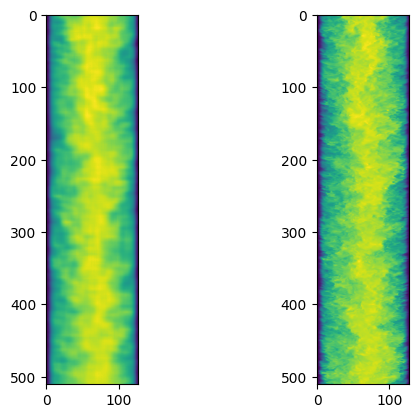

In [13]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(test_img[0,:,:])
axs[1].imshow(train_dataset[0,:,:,0])

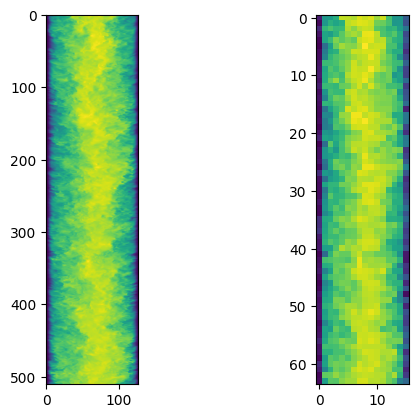

In [14]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(train_dataset[0,:,:,0])
axs[1].imshow(train_dataset[0,3::8,3::8,0])

In [15]:
model.save(history.model.name+".h5")


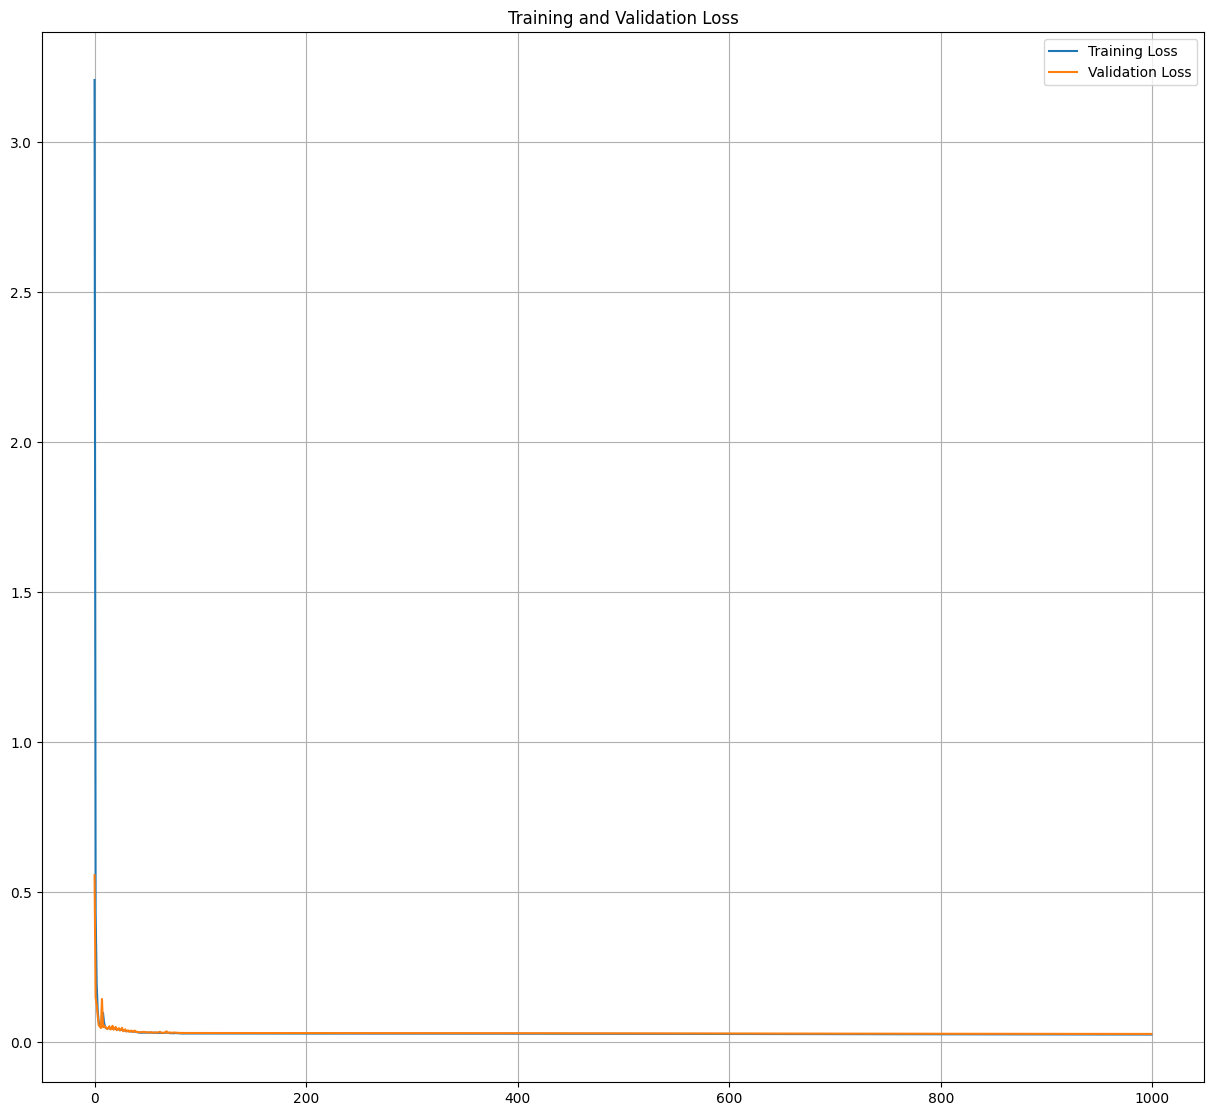

In [16]:



acc = history.history['mse']
val_acc = history.history['val_mse']

loss = history.history['loss']
val_loss = history.history['val_loss']



epochs_range = range(0, history.epoch[-1]+1)

plt.figure(figsize=(15, 30))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training MAE')
plt.plot(epochs_range, val_acc, label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.grid()

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.grid()

plt.show()
